# Optimization of diabetes prediction using Random Forest and XGBoost: A comparative study with the Pima Indian Diabetes dataset.

Autor: Marcos Aguilella Fabregat

In [1]:
#pip install pyampute
#pip install eli5
#pip install shap
#pip install skopt
#pip install scikit-optimize

## 1.1 Load libraries

In [2]:
# Python libraries
import pandas as pd
import numpy as np

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
#import ptitprince as pt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)


#Data  processing, metrics and modeling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
import lightgbm as lgbm
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from yellowbrick.classifier import DiscriminationThreshold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import shap
from skopt.searchcv import BayesSearchCV
from lazypredict.Supervised import LazyClassifier


# Stats
from pyampute.exploration.mcar_statistical_tests import MCARTest
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from statsmodels.tools import add_constant
import statsmodels.api as sm

# Imputation

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge, Ridge

In [3]:
# Time
from contextlib import contextmanager
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 

In [4]:
# print the JS visualization code to the notebook
shap.initjs()

## 1.2. Data reading

In [5]:
df = pd.read_csv('diabetes.csv')

# 2. Exploratory Data Analysis

First of all, a small sample of the data will be shown.

In [6]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0 33.60   
1            1       85             66             29        0 26.60   
2            8      183             64              0        0 23.30   
3            1       89             66             23       94 28.10   
4            0      137             40             35      168 43.10   

   DiabetesPedigreeFunction  Age  Outcome  
0                      0.63   50        1  
1                      0.35   31        0  
2                      0.67   32        1  
3                      0.17   21        0  
4                      2.29   33        1

Types of columns will also be shown:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [8]:
df.shape

(768, 9)

In [9]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [10]:
number_of_duplicates = df.duplicated().sum()
print(f"Number of duplicates: {number_of_duplicates}")

Number of duplicates: 0


At first glance, it can be checked that the dataset contains 9 columns with numeric values (6 int and 2 float) with 768 instances each. It seems that there are no null values. There are no duplicate data.

However, "Outcome" variables is not a numeric one, but a binary. So the type will be change in order to facilitate further analysis.

In [11]:
#df['Outcome'] = df['Outcome'].astype('category')

## 2.1 Data description

In [12]:
# Get the descriptive statistics of the DataFrame
describe_df = df.describe()

# Display the rounded DataFrame
describe_df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
count       768.00   768.00         768.00         768.00   768.00 768.00   
mean          3.85   120.89          69.11          20.54    79.80  31.99   
std           3.37    31.97          19.36          15.95   115.24   7.88   
min           0.00     0.00           0.00           0.00     0.00   0.00   
25%           1.00    99.00          62.00           0.00     0.00  27.30   
50%           3.00   117.00          72.00          23.00    30.50  32.00   
75%           6.00   140.25          80.00          32.00   127.25  36.60   
max          17.00   199.00         122.00          99.00   846.00  67.10   

       DiabetesPedigreeFunction    Age  Outcome  
count                    768.00 768.00   768.00  
mean                       0.47  33.24     0.35  
std                        0.33  11.76     0.48  
min                        0.08  21.00     0.00  
25%                        0.24  24.00     0.00  
50%                        0.37  29.00     0.00  
75%                        0.63  41.00     1.00  
max                        2.42  81.00     1.00

Various statistical values of the data are shown in this table. Among them, it is worth noting the minimum values of the variables ‘Glucose’, ‘BloodPressure’, ‘SkinThickness’, ‘Insulin’ and "BMI", since it is 0, which is not biologically possible. It is understood that these are null values and therefore, changes are made in order to be able to handle them correctly later on.

In [6]:
df_nan = df.copy()

In [7]:
df_nan[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df_nan[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

## 2.2 Missing values

In [15]:
missing_values = pd.DataFrame({'Null_count':df_nan.isna().sum(),'%_of_null_values':(df_nan.isnull().sum()/df.shape[0])*100})
missing_values

# Save dataframe into a CSV
missing_values.to_csv('./figuras/missing_values.csv', index=True)

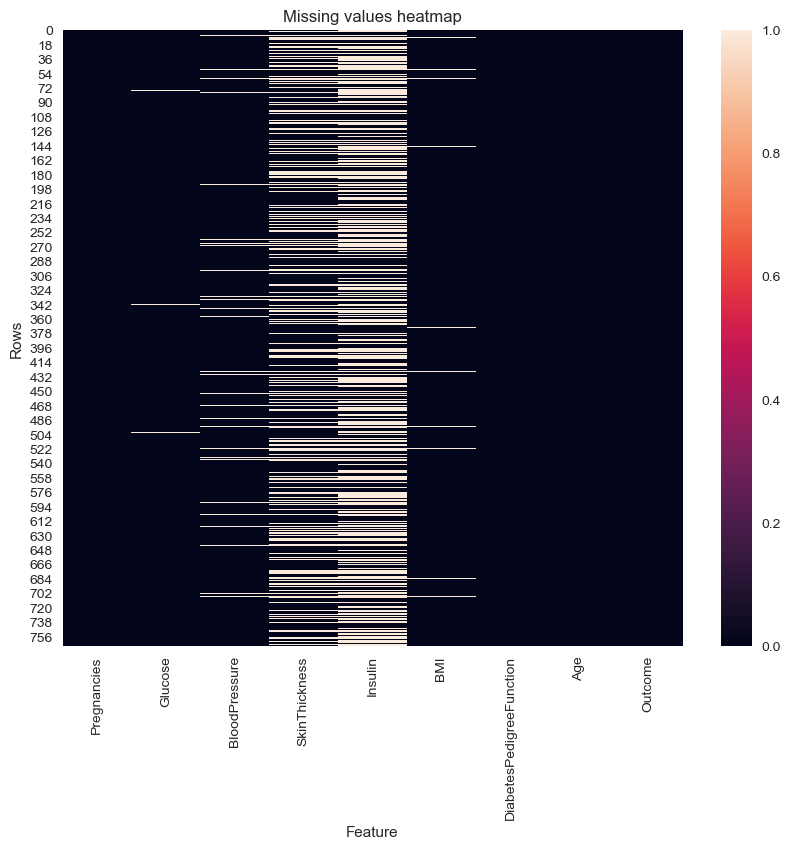

In [16]:
#sns.heatmap(df_nan.isna(),)
# Customize labels, title, etc. (optional)
plt.figure(figsize=(10, 8))
sns.heatmap(df_nan.isna(),)
plt.title('Missing values heatmap')
plt.xlabel('Feature')
plt.ylabel('Rows')
plt.savefig('./figuras/missing_values.png')

### Little's test

Little's Test is a statistical test used to determine whether missing data in a dataset is Missing Completely At Random (MCAR). Little's test uses a chi-square distribution to determine the test statistic based on the observed data patterns.

If the data is MCAR, missingness does not depend on observed or unobserved data. This implies that the missing data can be ignored without introducing bias into the analysis. Techniques like listwise deletion (removing rows with missing data) or mean imputation can be used without distorting the results.

If the data is not MCAR, missingness depends on observed or unobserved data. In this case, more sophisticated techniques, such as multiple imputation or maximum likelihood estimation, are required to handle the missing data appropriately to avoid bias.

**Reference**: 

*Roderick J. A. Little. (1988). A Test of Missing Completely at Random for Multivariate Data with Missing Values. Journal of the American Statistical Association, 83(404), 1198–1202. https://doi.org/10.2307/2290157*

In [17]:
mt = MCARTest(method="little")
print(mt.little_mcar_test(df_nan[0:7]))

0.3817820670959464


In [18]:
mt = MCARTest(method="ttest")
mcar_t_test = mt.mcar_t_tests(df_nan)
mcar_t_test

Pregnancies  Glucose  BloodPressure  SkinThickness  \
Pregnancies                       NaN      NaN            NaN            NaN   
Glucose                          0.40      NaN           0.42           0.92   
BloodPressure                    0.72     0.40            NaN           0.59   
SkinThickness                    0.00     0.29           0.00            NaN   
Insulin                          0.00     0.39           0.00           0.86   
BMI                              0.95     0.01           0.38           0.00   
DiabetesPedigreeFunction          NaN      NaN            NaN            NaN   
Age                               NaN      NaN            NaN            NaN   
Outcome                           NaN      NaN            NaN            NaN   

                          Insulin  BMI  DiabetesPedigreeFunction  Age  Outcome  
Pregnancies                   NaN  NaN                       NaN  NaN      NaN  
Glucose                       NaN 0.90                      0.39 0.34     0.84  
BloodPressure                 NaN 0.83                      0.06 0.13     0.20  
SkinThickness                 NaN 0.01                      0.00 0.00     0.15  
Insulin                       NaN 0.01                      0.00 0.00     0.26  
BMI                           NaN  NaN                      0.78 0.57     0.20  
DiabetesPedigreeFunction      NaN  NaN                       NaN  NaN      NaN  
Age                           NaN  NaN                       NaN  NaN      NaN  
Outcome                       NaN  NaN                       NaN  NaN      NaN

In [19]:
# Extract values < 0.05
filtered_p_values = mcar_t_test[mcar_t_test < 0.05]

print("\nFiltered p-values (less than 0.05):")
filtered_p_values



Filtered p-values (less than 0.05):


Pregnancies  Glucose  BloodPressure  SkinThickness  \
Pregnancies                       NaN      NaN            NaN            NaN   
Glucose                           NaN      NaN            NaN            NaN   
BloodPressure                     NaN      NaN            NaN            NaN   
SkinThickness                    0.00      NaN           0.00            NaN   
Insulin                          0.00      NaN           0.00            NaN   
BMI                               NaN     0.01            NaN           0.00   
DiabetesPedigreeFunction          NaN      NaN            NaN            NaN   
Age                               NaN      NaN            NaN            NaN   
Outcome                           NaN      NaN            NaN            NaN   

                          Insulin  BMI  DiabetesPedigreeFunction  Age  Outcome  
Pregnancies                   NaN  NaN                       NaN  NaN      NaN  
Glucose                       NaN  NaN                       NaN  NaN      NaN  
BloodPressure                 NaN  NaN                       NaN  NaN      NaN  
SkinThickness                 NaN 0.01                      0.00 0.00      NaN  
Insulin                       NaN 0.01                      0.00 0.00      NaN  
BMI                           NaN  NaN                       NaN  NaN      NaN  
DiabetesPedigreeFunction      NaN  NaN                       NaN  NaN      NaN  
Age                           NaN  NaN                       NaN  NaN      NaN  
Outcome                       NaN  NaN                       NaN  NaN      NaN

In [20]:
# Drop NaN values to see only the significant p-values
significant_p_values = filtered_p_values.stack() #convert df into a series

print("\nSignificant p-values (less than 0.05):")
significant_p_values


Significant p-values (less than 0.05):


SkinThickness  Pregnancies                0.00
               BloodPressure              0.00
               BMI                        0.01
               DiabetesPedigreeFunction   0.00
               Age                        0.00
Insulin        Pregnancies                0.00
               BloodPressure              0.00
               BMI                        0.01
               DiabetesPedigreeFunction   0.00
               Age                        0.00
BMI            Glucose                    0.01
               SkinThickness              0.00
dtype: float64

Little's test values show that the null hypothesis can be rejected (H0: missing data are MCAR) and therefore it could be said that the missing values are MAR or MNAR. That means these values are missing because of relationships with observable or unobservable variables.

However, rejecting the null hypothesis may not always mean that data is not MCAR, nor is accepting the null hypothesis a guarantee that data is MCAR *(1)*.


To deal with the null values in this dataset, estimators were used. Specifically, the Scikit-learn estimator ‘IterativeImputer’. Within it, the estimator chosen was ‘BayesianRidg()’.

This imputation method, rather than simply filling in missing values with a single estimate, performs multiple rounds to improve the quality of the estimates using a Bayesian approach to regression. This can be beneficial, especially when there are complex dependencies between variables.

**Reference**:

*1: Schouten, R. M., & Vink, G. (2021). The Dance of the Mechanisms: How Observed Information Influences the Validity of Missingness Assumptions. Sociological Methods & Research, 50(3), 1243-1258. https://doi.org/10.1177/0049124118799376*

In [8]:
# Initialize IterativeImputer
imputer = IterativeImputer(max_iter=50, random_state=10, estimator= BayesianRidge() ,verbose=True)

# Fit and transform the DataFrame to impute missing values
df_imputed = pd.DataFrame(imputer.fit_transform(df_nan), columns=df_nan.columns)

# Display information about missing values after imputation
print("\nNaN after imputation:")
print(df_imputed.isnull().sum())

[IterativeImputer] Completing matrix with shape (768, 9)
[IterativeImputer] Change: 194.2995687073597, scaled tolerance: 0.846 
[IterativeImputer] Change: 6.946367934236008, scaled tolerance: 0.846 
[IterativeImputer] Change: 2.7470978276655558, scaled tolerance: 0.846 
[IterativeImputer] Change: 1.088765009130782, scaled tolerance: 0.846 
[IterativeImputer] Change: 0.45870837133396947, scaled tolerance: 0.846 
[IterativeImputer] Early stopping criterion reached.

NaN after imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [22]:
df_imputed.describe()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
count       768.00   768.00         768.00         768.00   768.00 768.00   
mean          3.85   121.66          72.35          28.91   152.68  32.44   
std           3.37    30.49          12.15           9.52    97.38   6.88   
min           0.00    44.00          24.00           7.00   -19.50  18.20   
25%           1.00    99.00          64.00          22.11    90.00  27.50   
50%           3.00   117.00          72.00          28.48   130.13  32.05   
75%           6.00   141.00          80.00          35.00   190.00  36.60   
max          17.00   199.00         122.00          99.00   846.00  67.10   

       DiabetesPedigreeFunction    Age  Outcome  
count                    768.00 768.00   768.00  
mean                       0.47  33.24     0.35  
std                        0.33  11.76     0.48  
min                        0.08  21.00     0.00  
25%                        0.24  24.00     0.00  
50%                        0.37  29.00     0.00  
75%                        0.63  41.00     1.00  
max                        2.42  81.00     1.00

## 2.3 Data visualization

### Distribution pre- and post-imputation

In [23]:

def plot_overlaid_histograms(df_1, df_2, column, x_label='Value', y_label='Counts', color1='lightsalmon', color2='mediumorchid', alpha1=0.9, alpha2=0.5, savefig=False):
    """
    Plots a colum from two dataframes with matplotlib backend
    """
    pd.options.plotting.backend = 'matplotlib'
    title = f'Histogram of {column} before and after imputation'
    plt.title(title)

    df_1[column].hist(color=color1, alpha=alpha1, label=f'{df_1[column].name} before')
    df_2[column].hist(color=color2, alpha=alpha2, label=f'{df_2[column].name} now')

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    if(savefig):
        plt.savefig(f'./figuras/{title}', bbox_inches='tight')
    plt.show()

In [68]:
import plotly.graph_objects as go
import pandas as pd

def plot_overlaid_histograms_plotly(df_1, df_2, column, x_label='Value', y_label='Counts', color1='lightsalmon', color2='mediumorchid', alpha1=0.9, alpha2=0.5, savefig=False):
    """
    Plots a column from two dataframes with plotly backend
    """
    title = f'Histogram of {column} before and after imputation'

    # Create histograms
    fig = go.Figure()

    fig.add_trace(go.Histogram(
        x=df_1[column],
        opacity=alpha1,
        name=f'{df_1[column].name} before',
        marker_color=color1
    ))

    fig.add_trace(go.Histogram(
        x=df_2[column],
        opacity=alpha2,
        name=f'{df_2[column].name} now',
        marker_color=color2
    ))

    # Update layout
    fig.update_layout(
        title=title,
        xaxis_title=x_label,
        yaxis_title=y_label,
        barmode='overlay',
        legend=dict(x=0.1, y=0.9)
    )

    if savefig:
        fig.write_image(f'./figuras/{title}.png', scale=2)

    fig.show()


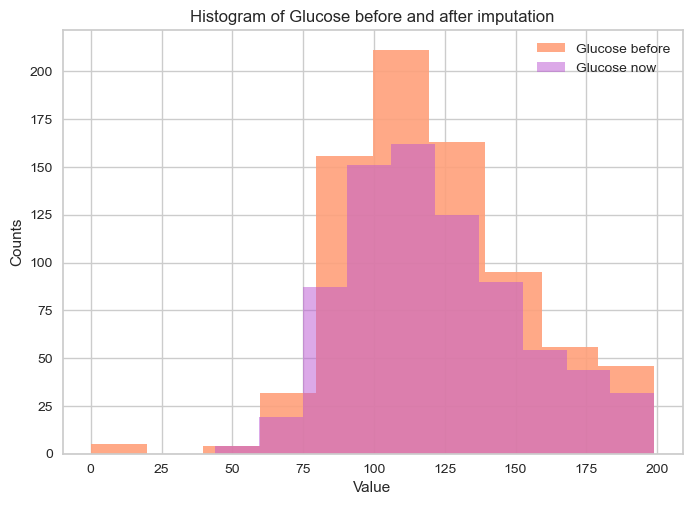

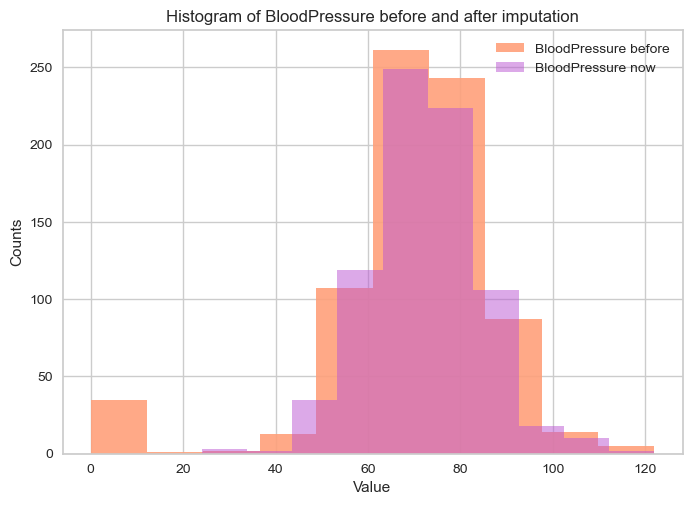

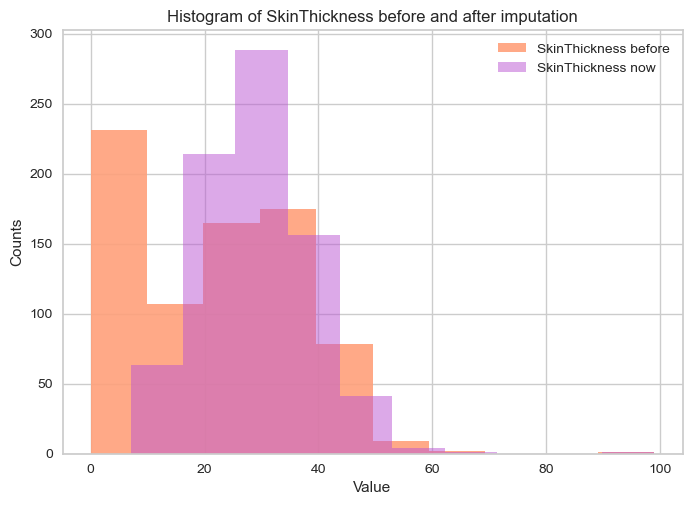

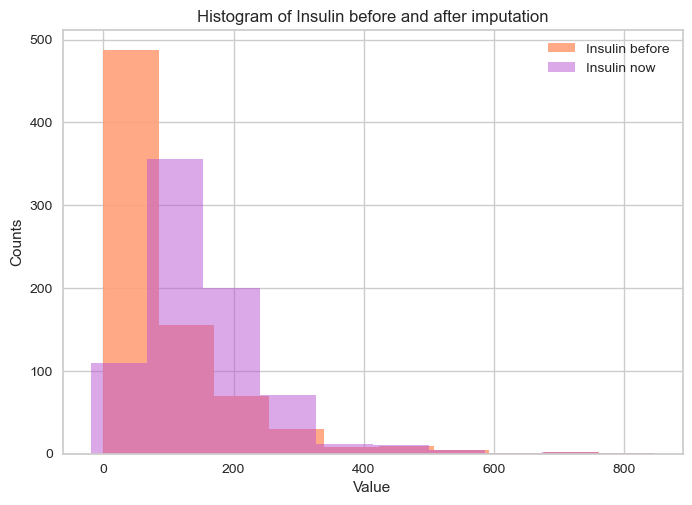

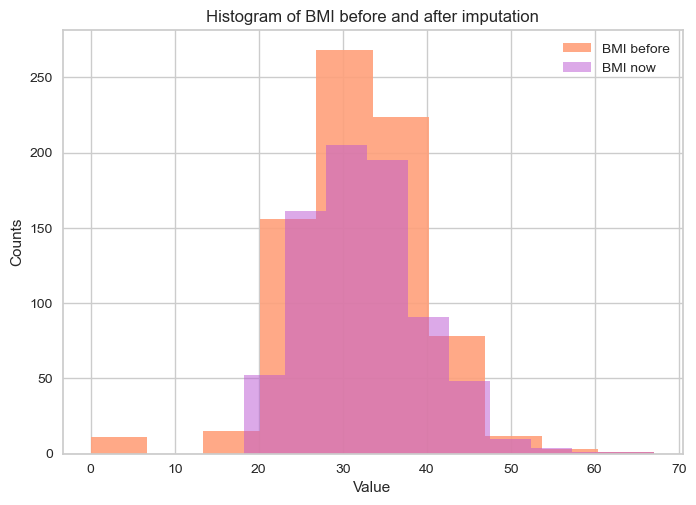

In [24]:
columns = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for i,_ in enumerate(columns):
    plot_overlaid_histograms(df, df_imputed, columns[i], savefig= False)
    

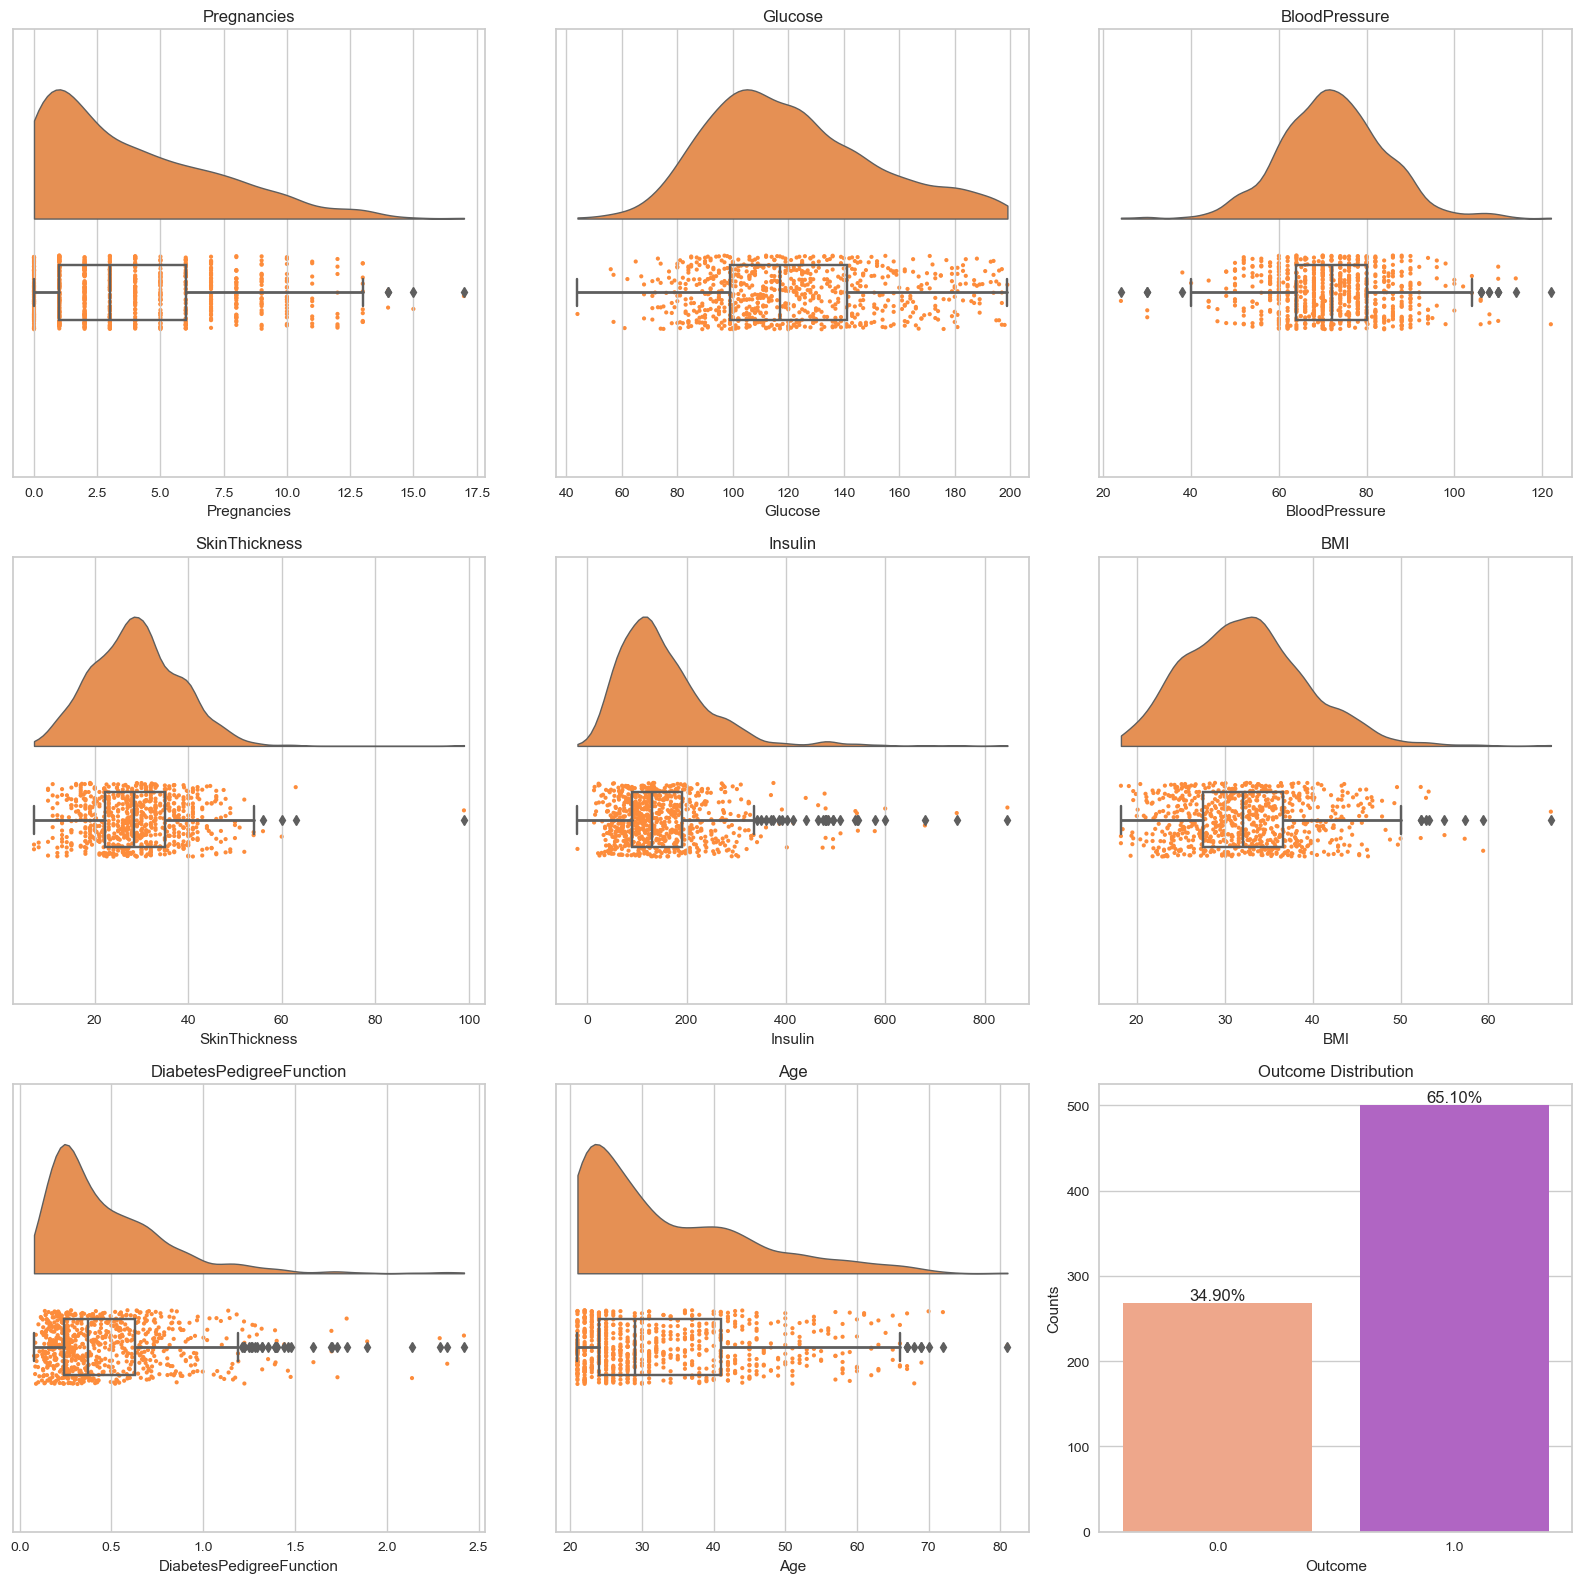

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt

# Assuming that the df_imputed DataFrame has already been loaded and that 'variables' contains the desired columns
variables = df_imputed.columns[0:8]

# Calculate the number of rows and columns needed
num_filas = 3
num_columnas = 3

# Create a figure with subplots for each variable
fig, axs = plt.subplots(nrows=num_filas, ncols=num_columnas, figsize=(16, 16))

# Flatten the axis list for easier iteration
axs_flat = axs.flatten()

# Iterate over the variables and create a raincloud plot for each one
for i, variable in enumerate(variables):
    ax = axs_flat[i]
    pt.RainCloud(data=df_imputed, y=variable, orient='h', ax=ax, palette='Oranges')
    ax.set_title(variable)

# Add the bar chart in the last position of the grid
ax = axs_flat[len(variables)]
sns.countplot(data=df_imputed["Outcome"], x=df_imputed["Outcome"], palette=["lightsalmon", "mediumorchid"])

# Set labels and title for the bar chart
ax.set_xlabel("Outcome")
ax.set_ylabel('Counts')
ax.set_title('Outcome Distribution')

# Add the proportions to the columns
total = len(df_imputed["Outcome"])
for p in plt.gca().patches:  # Use plt.gca() to get the current axis
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height, f'{height/total:.2%}', ha="center", va="bottom")

# Adjust the layout of the figure
plt.tight_layout()

# Save the figure as a .png file
plt.savefig('./figuras/combined_features_distribution.png', bbox_inches='tight')
plt.show()


## Statiscal analysis

### Assessing normality and skewness of the distributions of the variables

This script assesses the normality and skewness of the variables.

The **Shapiro-Wilk** test is used to evaluate whether a sample comes from a normally distributed population.

The **skew test (D'Agostino's K^2 test)** checks for the presence and direction of skewness in the data, indicating whether the distribution is left-skewed or right-skewed.


In [10]:
import pandas as pd
import scipy.stats as ss

# Create an empty list to store the DataFrames
result_dfs = []

# Iterate over each variable and assess normality and skewness
for column in df_imputed.columns[0:7]:
    data = df_imputed[column]

    # Perform the Shapiro-Wilk test
    shapiro_statistic, shapiro_p_value = ss.shapiro(data)
    
    # Perform the skew test
    skew_statistic, skew_p_value = ss.skewtest(data)

    # Determine normality interpretation
    normality_interpretation = "Follows a normal distribution" if shapiro_p_value > 0.05 else "Does not follow a normal distribution"

    # Determine skewness interpretation
    if skew_p_value < 0.05:
        if skew_statistic < 0:
            skewness_interpretation = "Left-skewed (negatively skewed)"
        else:
            skewness_interpretation = "Right-skewed (positively skewed)"
    else:
        skewness_interpretation = "Not significantly skewed"

    # Create a DataFrame for the test results
    results = pd.DataFrame({
        'Variable': [column],
        'Shapiro test statistic': [shapiro_statistic],
        'Shapiro test p-value': [shapiro_p_value],
        'Normality Interpretation': [normality_interpretation],
        'Skew test statistic': [skew_statistic],
        'Skew test p-value': [skew_p_value],
        'Skewness Interpretation': [skewness_interpretation]
    })

    # Add the DataFrame to the list
    result_dfs.append(results)

# Concatenate all DataFrames in the list into a single DataFrame
final_results = pd.concat(result_dfs, ignore_index=True)

# Display the results DataFrame
final_results

Variable  Shapiro test statistic  Shapiro test p-value  \
0               Pregnancies                    0.90                  0.00   
1                   Glucose                    0.97                  0.00   
2             BloodPressure                    0.99                  0.00   
3             SkinThickness                    0.97                  0.00   
4                   Insulin                    0.85                  0.00   
5                       BMI                    0.98                  0.00   
6  DiabetesPedigreeFunction                    0.84                  0.00   

                Normality Interpretation  Skew test statistic  \
0  Does not follow a normal distribution                 8.90   
1  Does not follow a normal distribution                 5.71   
2  Does not follow a normal distribution                 1.68   
3  Does not follow a normal distribution                 7.51   
4  Does not follow a normal distribution                15.87   
5  Does not follow a normal distribution                 6.39   
6  Does not follow a normal distribution                14.91   

   Skew test p-value           Skewness Interpretation  
0               0.00  Right-skewed (positively skewed)  
1               0.00  Right-skewed (positively skewed)  
2               0.09          Not significantly skewed  
3               0.00  Right-skewed (positively skewed)  
4               0.00  Right-skewed (positively skewed)  
5               0.00  Right-skewed (positively skewed)  
6               0.00  Right-skewed (positively skewed)

### Analysis of correlations

In [27]:
df_num = df_imputed.drop(columns=['Outcome'])
df_binary = df_imputed[['Outcome']]
df_binary = df_binary.astype('category')

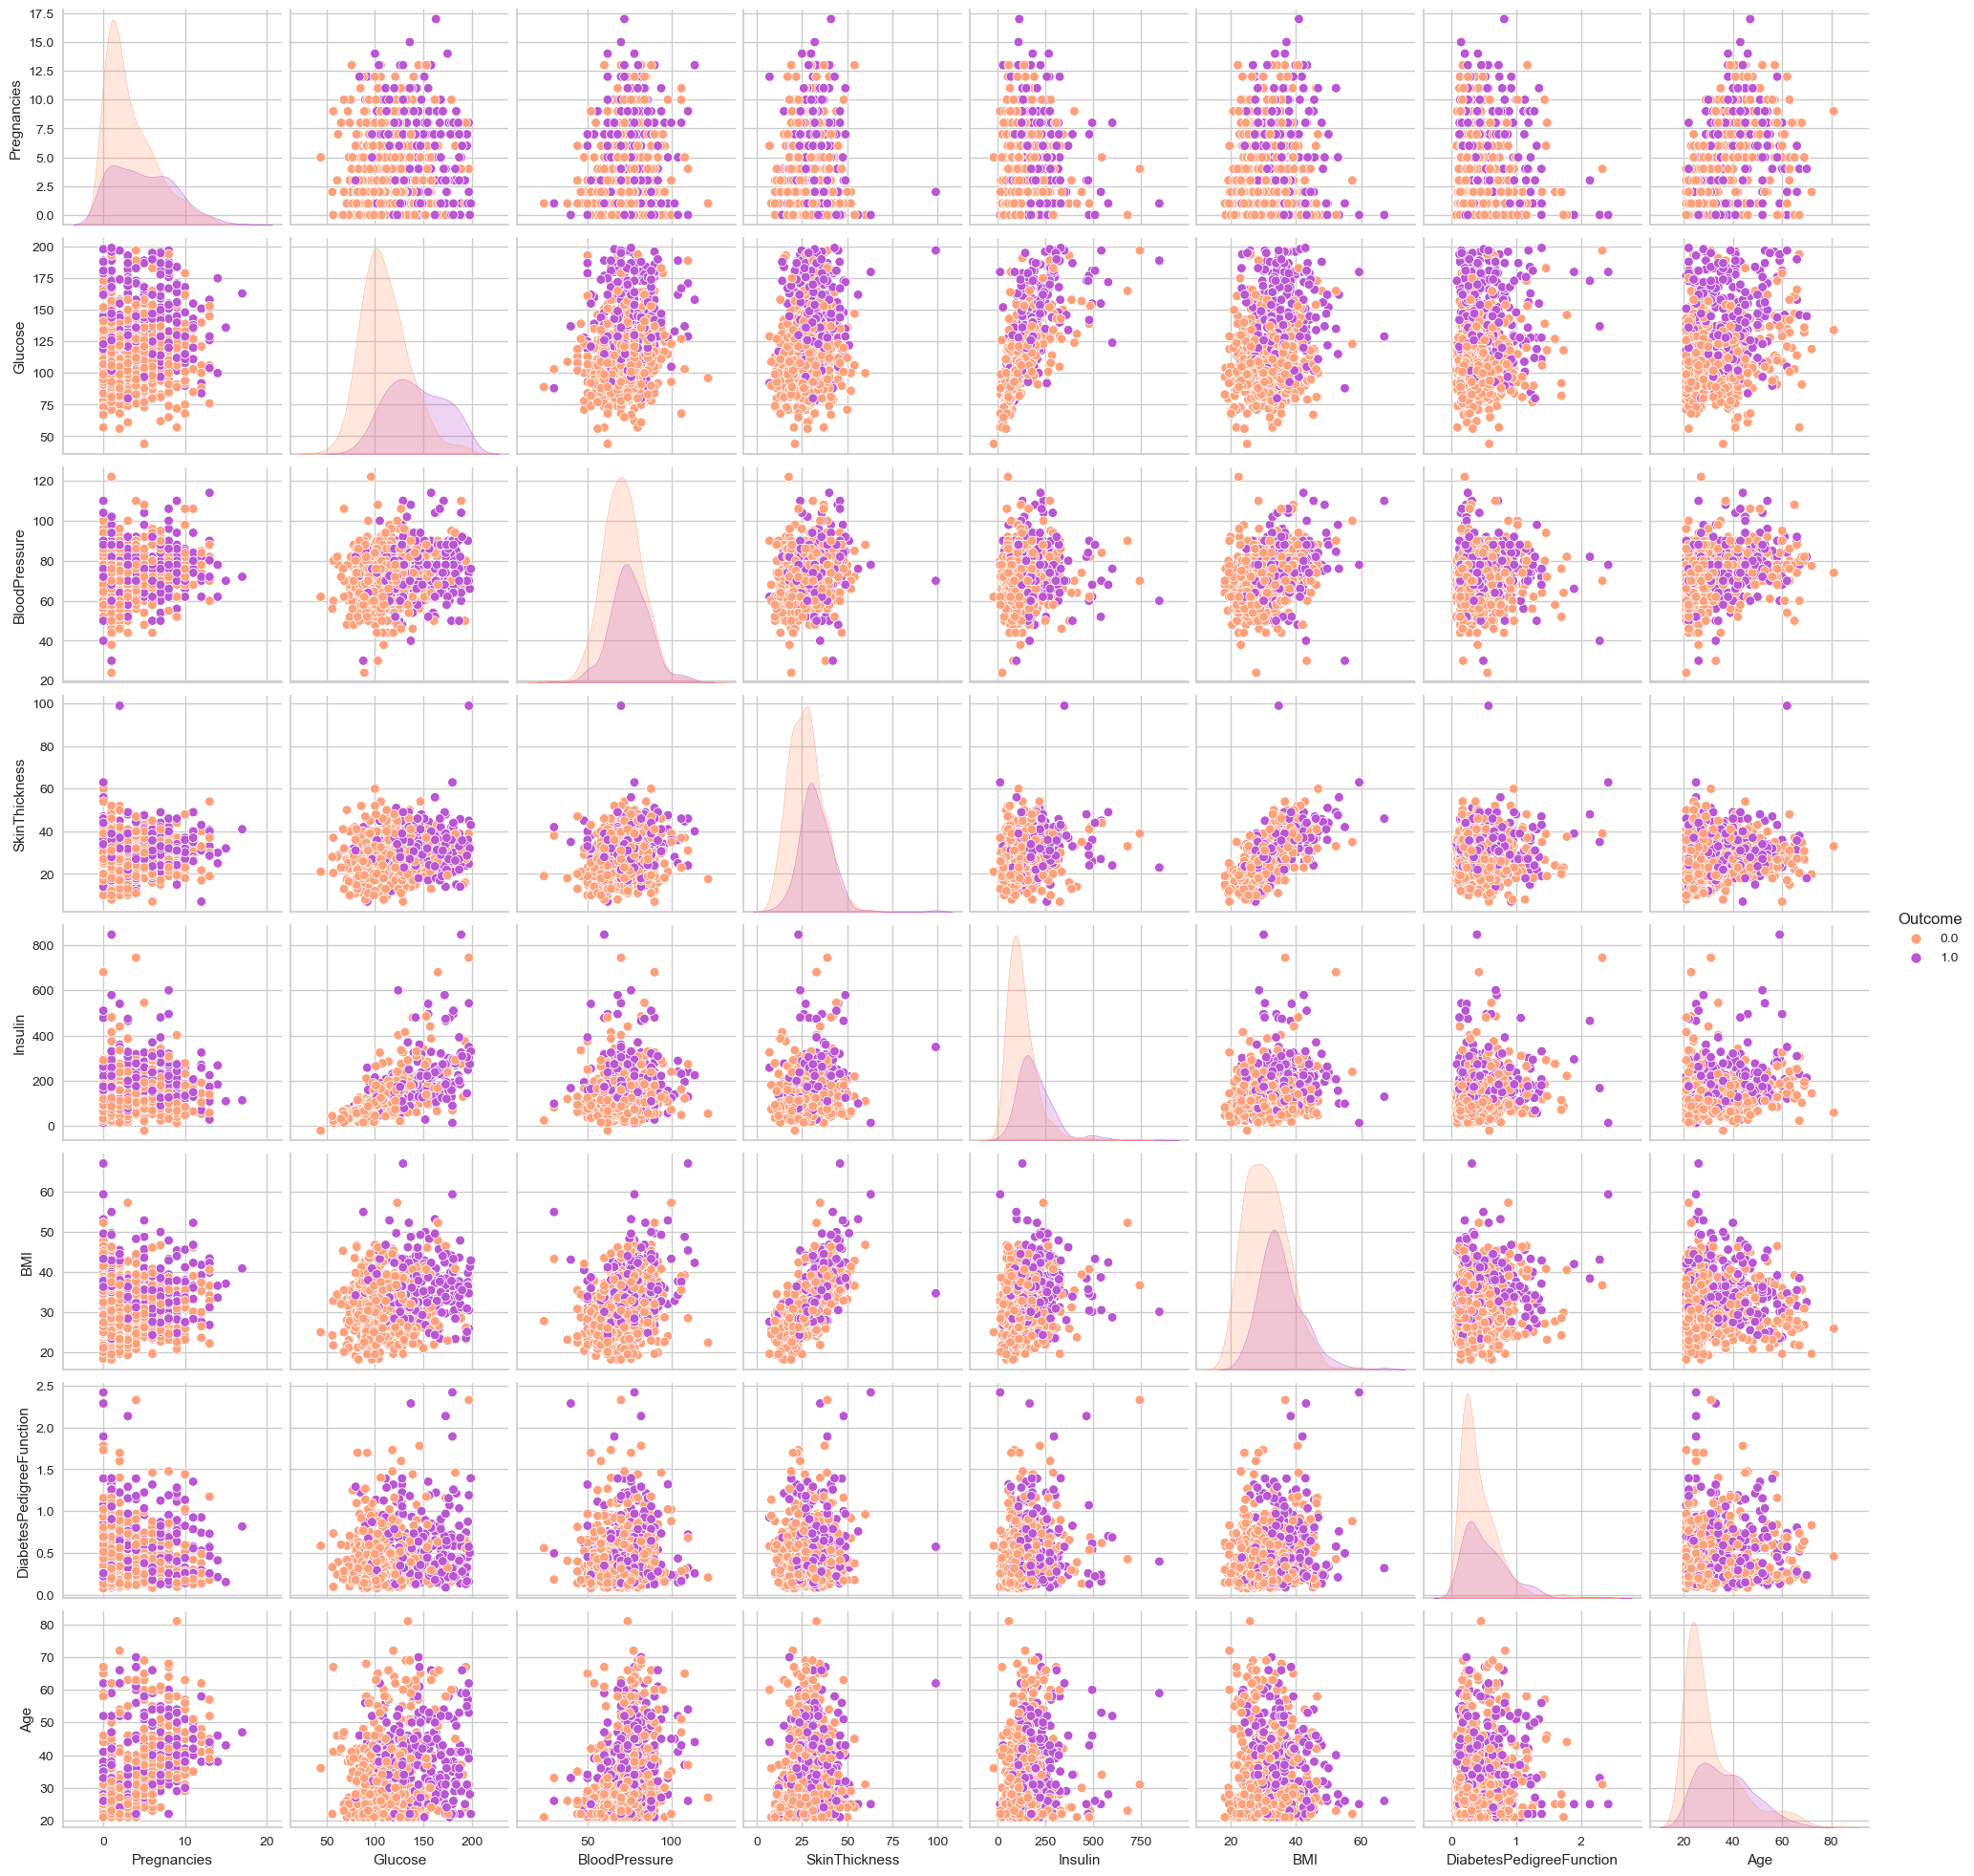

In [28]:
#p=sns.pairplot(df_imputed[0:7], hue = df_imputed['Outcome'])
p=sns.pairplot(df_imputed, hue = 'Outcome', palette=["lightsalmon", "mediumorchid"])

Text(0.5, 1.02, 'Gráfico por pares de variables con fuerte correlación')

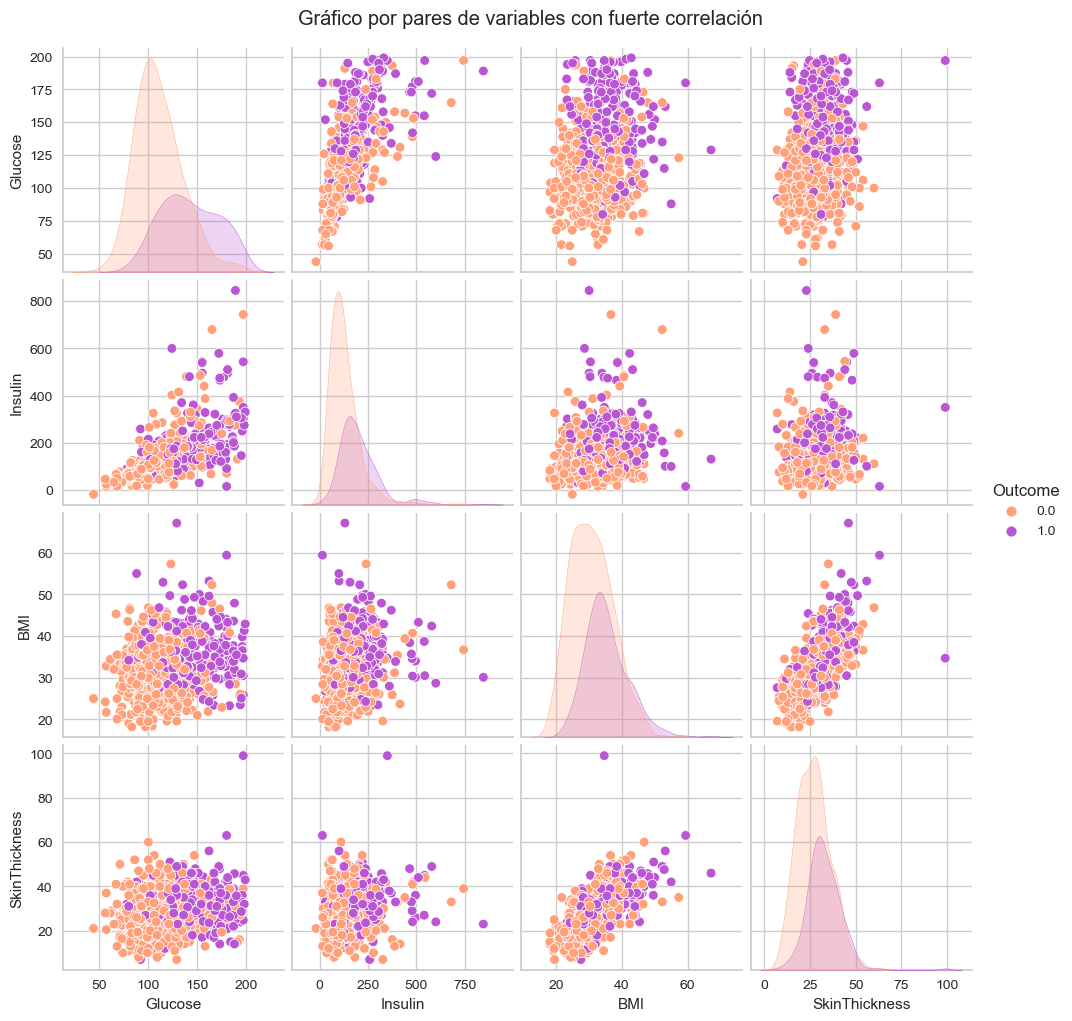

In [29]:
p = sns.pairplot(df_imputed[["Glucose", "Insulin", "BMI", "SkinThickness", "Outcome"]], hue='Outcome', palette=["lightsalmon", "mediumorchid"])
p.fig.suptitle('Gráfico por pares de variables con fuerte correlación', y=1.02)


In [80]:
df_pairplot = df_imputed[["Glucose", "Insulin", "BMI", "SkinThickness", "Outcome"]]
df_pairplot

Glucose  Insulin   BMI  SkinThickness  Outcome
0     148.00   218.90 33.60          35.00     1.00
1      85.00    70.31 26.60          29.00     0.00
2     183.00   268.51 23.30          21.54     1.00
3      89.00    94.00 28.10          23.00     0.00
4     137.00   168.00 43.10          35.00     1.00
..       ...      ...   ...            ...      ...
763   101.00   180.00 32.90          48.00     0.00
764   122.00   158.73 36.80          27.00     0.00
765   121.00   112.00 26.20          23.00     0.00
766   126.00   173.48 30.10          27.91     1.00
767    93.00    87.31 30.40          31.00     0.00

[768 rows x 5 columns]

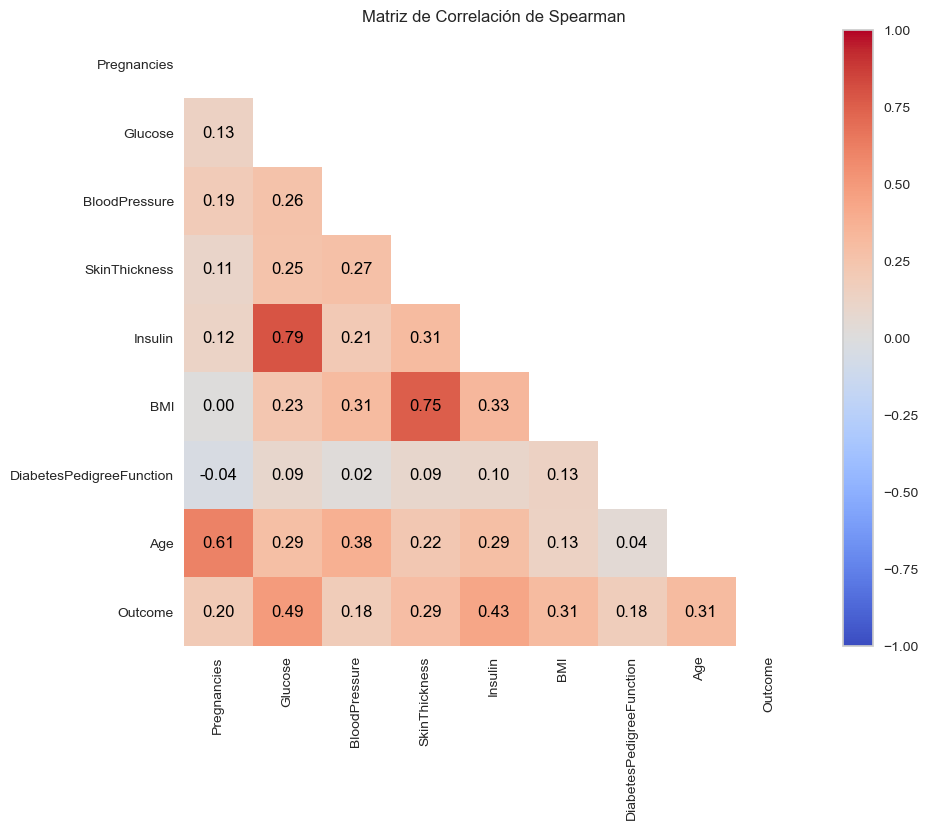

In [30]:
# Calculate the Spearman correlation matrix
spearman_corr = df_imputed.corr(method='spearman')

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))

# Apply the mask, setting the upper triangle to NaN
spearman_corr_masked = spearman_corr.mask(mask)

# Set the figure size
plt.figure(figsize=(10, 8))

# Create the heatmap manually using matplotlib
plt.imshow(spearman_corr_masked, cmap='coolwarm', interpolation='none', aspect='auto', vmin=-1, vmax=1)
plt.colorbar()

# Remove the borders of each cell
plt.gca().spines[:].set_visible(False)

# Add labels
plt.xticks(np.arange(len(spearman_corr.columns)), spearman_corr.columns, rotation=90)
plt.yticks(np.arange(len(spearman_corr.columns)), spearman_corr.columns)

# Add annotations
for i in range(len(spearman_corr.columns)):
    for j in range(len(spearman_corr.columns)):
        if not mask[i, j]:
            plt.text(j, i, f"{spearman_corr.iloc[i, j]:.2f}", ha="center", va="center", color="black")

# Add title
plt.title('Spearman Correlation Matrix')
plt.grid(None)

# Show the plot
plt.show()


## Machine learning and deep learning

In [31]:
features_df = df_imputed.drop(columns=['Outcome'])
target = df_imputed[['Outcome']]

## With SMOTE

In [105]:
## Balancing the data
from imblearn.over_sampling import SMOTE
X = features_df
y = target

X_train, X_test_SMOTE, y_train, y_test_SMOTE = train_test_split(X, y, test_size=.20, random_state=5)

smote = SMOTE(sampling_strategy= 0.9 , random_state=42)
X_SMOTE, y_SMOTE = smote.fit_resample(X_train, y_train)


In [33]:
print("Values in training data before Smote:")
print(y_train.value_counts())
print("Values in training data after Smote:")
print(y_SMOTE.value_counts())

Values in training data before Smote:
Outcome
0.00       400
1.00       214
Name: count, dtype: int64
Values in training data after Smote:
Outcome
0.00       400
1.00       360
Name: count, dtype: int64


In [34]:
print("Percentage of Positive Values in training data after Smote :",y_SMOTE.value_counts(normalize=True)[1]/(y_SMOTE.value_counts(normalize=True)[0]+y_SMOTE.value_counts(normalize=True)[1])*100,"%")
print("Percentage of Negative Values in training data after Smote :",y_SMOTE.value_counts(normalize=True)[0]/(y_SMOTE.value_counts(normalize=True)[0]+y_SMOTE.value_counts(normalize=True)[1])*100,"%")

Percentage of Positive Values in training data after Smote : 47.368421052631575 %
Percentage of Negative Values in training data after Smote : 52.63157894736842 %


In [35]:
print("Percentage of Positive Values in training data before Smote :",y_train.value_counts(normalize=True)[1]/(y_train.value_counts(normalize=True)[0]+y_train.value_counts(normalize=True)[1])*100,"%")
print("Percentage of Negative Values in training data abefore Smote :",y_train.value_counts(normalize=True)[0]/(y_train.value_counts(normalize=True)[0]+y_train.value_counts(normalize=True)[1])*100,"%")

Percentage of Positive Values in training data before Smote : 34.85342019543974 %
Percentage of Negative Values in training data abefore Smote : 65.14657980456026 %


In [36]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_SMOTE, X_test_SMOTE, y_SMOTE, y_test_SMOTE)
#print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  9.65it/s]


In [37]:
#print(models)

In [38]:
from sklearn.ensemble import RandomForestClassifier
# Training and fitting a Random Forest Model
my_model_2 = RandomForestClassifier(n_estimators=100,
                                  random_state=0)

my_model_2.fit(X_SMOTE, y_SMOTE)

RandomForestClassifier(random_state=0)

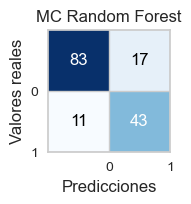

In [106]:
y_pred_class_SMOTE = my_model_2.predict(X_test_SMOTE)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_SMOTE, y_pred_class_SMOTE)

# Crear un mapa de calor usando Matplotlib
plt.figure(figsize=(4, 2))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.title('MC Random Forest', fontsize=12)
#plt.colorbar()

# Anotar los números en el mapa de calor
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             ha="center", va="center",
             color="white" if conf_matrix[i, j] > thresh else "black", fontsize=12)
    
plt.xticks(np.arange(len(conf_matrix)) + 0.5, ['0', '1'], rotation=0)
plt.yticks(np.arange(len(conf_matrix)) + 0.5, ['0', '1'])

plt.tight_layout()
plt.ylabel('Valores reales', fontsize=12)
plt.xlabel('Predicciones', fontsize=12)
#plt.savefig('./figuras/conf_matrix_smote.png')
plt.show()

In [40]:
print(classification_report(y_test_SMOTE, y_pred_class_SMOTE))

              precision    recall  f1-score   support

         0.0       0.88      0.83      0.86       100
         1.0       0.72      0.80      0.75        54

    accuracy                           0.82       154
   macro avg       0.80      0.81      0.81       154
weighted avg       0.82      0.82      0.82       154



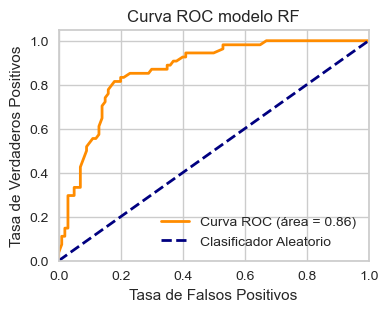

In [41]:
# Get the prediction probabilities for the test set
y_prob_RF = my_model_2.predict_proba(X_test_SMOTE)[:, 1]

# Calculate the ROC curve
fpr_RF, tpr_RF, thresholds = roc_curve(y_test_SMOTE, y_prob_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)

# Plot the ROC curve
plt.figure(figsize=(4, 3))
plt.plot(fpr_RF, tpr_RF, color='darkorange', lw=2, label='ROC Curve (area = %0.2f)' % roc_auc_RF)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve RF model')
plt.legend(loc="lower right")
plt.show()


In [42]:
# Calculating and Displaying importance using the eli5 library
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model_2, random_state=1).fit(X_test_SMOTE,y_test_SMOTE)
eli5.show_weights(perm, feature_names = X_test_SMOTE.columns.tolist())

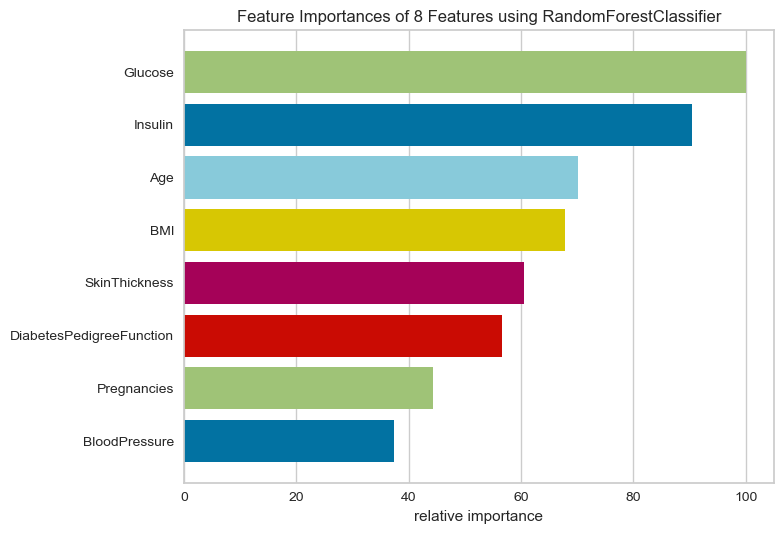

<Axes: title={'center': 'Feature Importances of 8 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [43]:
from yellowbrick.model_selection import FeatureImportances

viz = FeatureImportances(my_model_2)
viz.fit(X_SMOTE, y_SMOTE)
#plt.savefig('./figuras/feature_importances_rf.png')
viz.show()

## Fine tuning parameter of RF using BayesSearchCV

In [44]:
from skopt.searchcv import BayesSearchCV
# Parameter definition
params = {
    "n_estimators": np.arange(50, 200, 25),
    "max_depth": np.arange(5, 15, 2),
    "criterion": ["gini", "entropy"],
    "class_weight" : ["balanced", "balanced_subsample"],
    "max_samples" : [0.3, 0.5, 0.8],
    'max_features': np.arange(0.1, 1, 0.1),

}
     

# Definition of the search espace
search = BayesSearchCV(
    estimator=RandomForestClassifier(),
    search_spaces=params,
    n_jobs=1,
    cv=3,
    n_iter=20,
    scoring="accuracy",
    verbose=4,
    random_state=42
)

In [2]:
# Search
search.fit(X_SMOTE, y_SMOTE)

In [46]:
# Print best model
print(search.best_params_)

OrderedDict([('class_weight', 'balanced_subsample'), ('criterion', 'gini'), ('max_depth', 9), ('max_features', 0.7000000000000001), ('max_samples', 0.8), ('n_estimators', 150)])


In [47]:
Model = RandomForestClassifier(n_estimators=50, class_weight= "balanced_subsample", criterion= 'gini', max_depth = 11, max_samples =  0.8, verbose = 0, max_features = 0.7)
Model.fit(X_SMOTE, y_SMOTE)

Model.score(X_test_SMOTE, y_test_SMOTE)

0.7792207792207793

In [48]:
import copy
# Adjust the random forest without showing the warning
warnings.filterwarnings("ignore", category=UserWarning)

# Create the model
Model = RandomForestClassifier(n_estimators=100, class_weight="balanced", criterion='gini', max_depth=13, max_samples=0.8, verbose=0, max_features=0.5)
Model.fit(X_SMOTE, y_SMOTE)
Model.score(X_test_SMOTE, y_test_SMOTE)

# Create the list to store model ID and accuracy
Model_accs = []
for idx, tree in enumerate(Model.estimators_):
    Score = tree.score(X_test_SMOTE, y_test_SMOTE)  # Find the accuracy of each tree
    Model_accs.append([idx, Score])
Model_accs = np.array(Model_accs)

# Sort by the second column in reverse order to get the ranking order
sorted_indices = np.argsort(Model_accs[:, 1])[::-1]

# Get the list of model IDs according to the sorted model accuracies
Model_ids = Model_accs[sorted_indices][:, 0].astype(int)

# Create a numpy array, reorder the models, and convert it back to a list
Model.estimators_ = np.array(Model.estimators_)[Model_ids].tolist()

# Array to store the cumulative score of smaller models
Result = []
Total_models = len(Model.estimators_)
for k in range(2, Total_models):
    Small_model = copy.deepcopy(Model)  # Create a copy of the current model
    # Set its trees to the first 'k' trees of the original model
    Small_model.estimators_ = Model.estimators_[:k]
    # Calculate the score of the smaller model
    Score = Small_model.score(X_test_SMOTE, y_test_SMOTE)
    Result.append([k, Score])


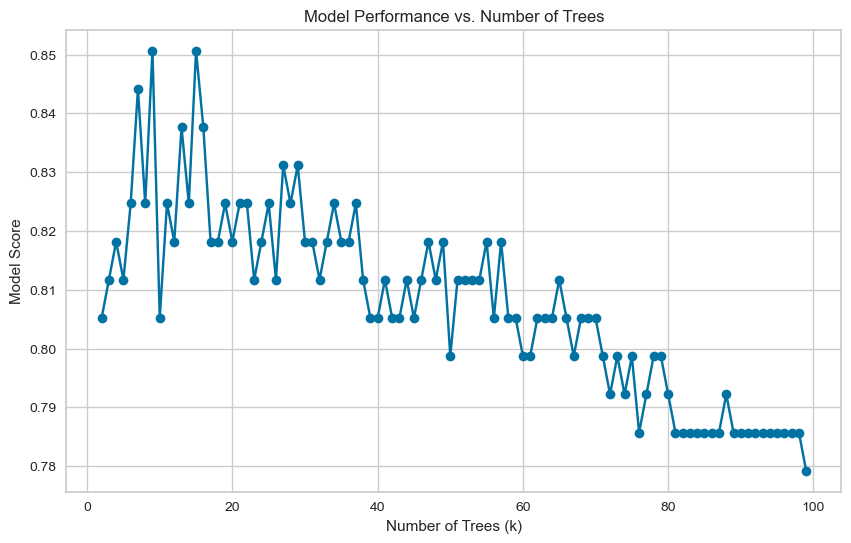

In [49]:
ks = [entry[0] for entry in Result]
scores = [entry[1] for entry in Result]

plt.figure(figsize=(10, 6))
plt.plot(ks, scores, marker='o', linestyle='-')
plt.title('Model Performance vs. Number of Trees')
plt.xlabel('Number of Trees (k)')
plt.ylabel('Model Score')
plt.grid(True)

#plt.savefig('./figuras/performances_trees_rf.png')

plt.show()

In [50]:
best_small_model = copy.deepcopy(Model)

best_small_model.estimators_ = Model.estimators_[:14]
best_small_model.score(X_test_SMOTE, y_test_SMOTE)

0.8246753246753247

In [51]:
y_pred = best_small_model.predict(X_test_SMOTE)
print(classification_report(y_test_SMOTE, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87       100
         1.0       0.75      0.74      0.75        54

    accuracy                           0.82       154
   macro avg       0.81      0.81      0.81       154
weighted avg       0.82      0.82      0.82       154



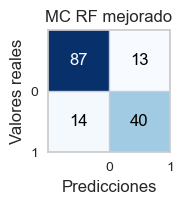

In [52]:
y_pred_class_RF_mod = best_small_model.predict(X_test_SMOTE)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_SMOTE, y_pred_class_RF_mod)

# Create a heatmap using Matplotlib
plt.figure(figsize=(4, 2))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.title('Enhanced RF Confusion Matrix', fontsize=12)
#plt.colorbar()

# Annotate the numbers on the heatmap
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             ha="center", va="center",
             color="white" if conf_matrix[i, j] > thresh else "black", fontsize=12)
    
plt.xticks(np.arange(len(conf_matrix)) + 0.5, ['0', '1'], rotation=0)
plt.yticks(np.arange(len(conf_matrix)) + 0.5, ['0', '1'])

plt.tight_layout()
plt.ylabel('True Values', fontsize=12)
plt.xlabel('Predictions', fontsize=12)
#plt.savefig('./figures/conf_matrix_RF_mod.png')
plt.show()


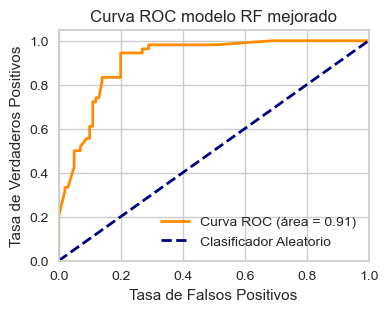

In [55]:
y_prob_RF_mod = best_small_model.predict_proba(X_test_SMOTE)[:, 1]

# Calculating ROC curve
fpr_RF_mod, tpr_RF_mod, thresholds = roc_curve(y_test_SMOTE, y_prob_RF_mod)
roc_auc_RF_mod = auc(fpr_RF_mod, tpr_RF_mod)

# ROC curve
plt.figure(figsize=(4, 3))
plt.plot(fpr_RF_mod, tpr_RF_mod, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc_RF_mod)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador Aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC modelo RF mejorado')
plt.legend(loc="lower right")
plt.show()

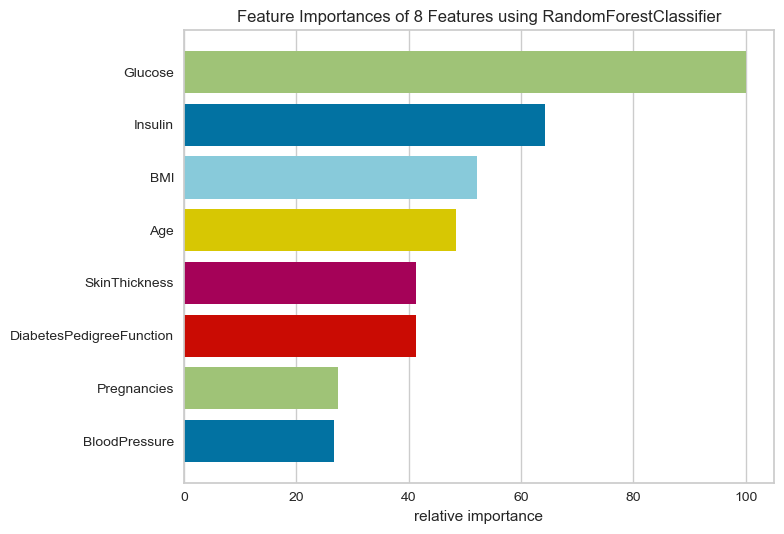

<Axes: title={'center': 'Feature Importances of 8 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [56]:
from yellowbrick.model_selection import FeatureImportances

viz = FeatureImportances(best_small_model)
viz.fit(X_SMOTE, y_SMOTE)
plt.savefig('./figuras/feature_importances_best_model_rf.png')
viz.show()

## XGBoost model

In [58]:
import xgboost

d_train = xgboost.DMatrix(X_SMOTE, label=y_SMOTE)
d_test = xgboost.DMatrix(X_test_SMOTE, label=y_test_SMOTE)

In [59]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_SMOTE),
    "eval_metric": "logloss",
}
model = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=20,
)

[0]	test-logloss:0.67562
[100]	test-logloss:0.49735
[200]	test-logloss:0.44528
[300]	test-logloss:0.43510
[344]	test-logloss:0.43386


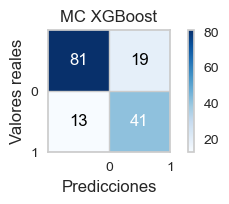

In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Convert the test set into DMatrix
d_test = xgboost.DMatrix(X_test_SMOTE)

# Get the predicted probabilities or classes
y_pred_prob = model.predict(d_test)  # Predicted probabilities
y_pred_class = (y_pred_prob > 0.5).astype(int)  # Predicted classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_SMOTE, y_pred_class)

# Crear un mapa de calor usando Matplotlib
plt.figure(figsize=(4, 2))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.title('MC XGBoost', fontsize=12)
plt.colorbar()

# Anotar los números en el mapa de calor
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             ha="center", va="center",
             color="white" if conf_matrix[i, j] > thresh else "black", fontsize=12)
    
plt.xticks(np.arange(len(conf_matrix)) + 0.5, ['0', '1'], rotation=0)
plt.yticks(np.arange(len(conf_matrix)) + 0.5, ['0', '1'])

plt.tight_layout()
plt.ylabel('Valores reales', fontsize=12)
plt.xlabel('Predicciones', fontsize=12)
plt.savefig('./figuras/conf_matrix_XGBoost.png')
plt.show()

#print("Confusion Matrix:")
#print(conf_matrix)

In [61]:
print(classification_report(y_test_SMOTE, y_pred_class))

              precision    recall  f1-score   support

         0.0       0.86      0.81      0.84       100
         1.0       0.68      0.76      0.72        54

    accuracy                           0.79       154
   macro avg       0.77      0.78      0.78       154
weighted avg       0.80      0.79      0.79       154



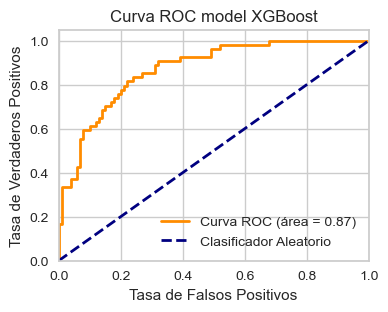

In [62]:
y_prob_XGBoost = model.predict(xgboost.DMatrix(X_test_SMOTE), ntree_limit=model.best_iteration+1)


fpr_XGBoost, tpr_XGBoost, thresholds = roc_curve(y_test_SMOTE, y_prob_XGBoost)
roc_auc_XGBoost = auc(fpr_XGBoost, tpr_XGBoost)


plt.figure(figsize=(4, 3))
plt.plot(fpr_XGBoost, tpr_XGBoost, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc_XGBoost)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador Aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC model XGBoost')
plt.legend(loc="lower right")
plt.show()

## Use of SHAP values to calculate feature importance

In [65]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_SMOTE)

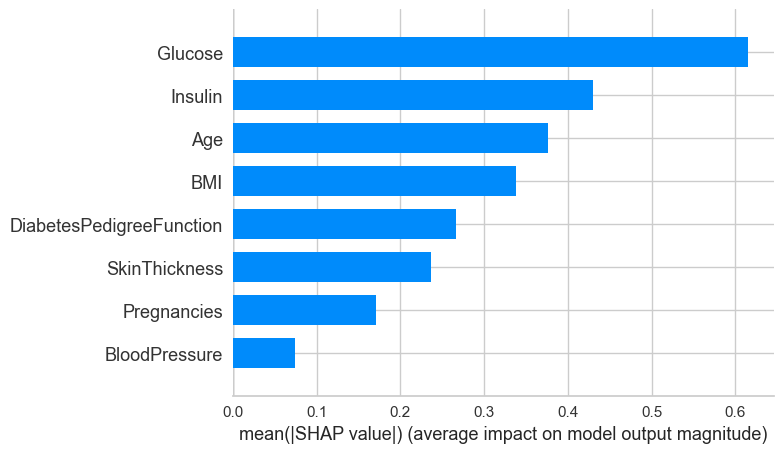

In [66]:
shap.summary_plot(shap_values, X_SMOTE, plot_type="bar")
#plt.savefig('./figuras/shap_summary_plot.png')

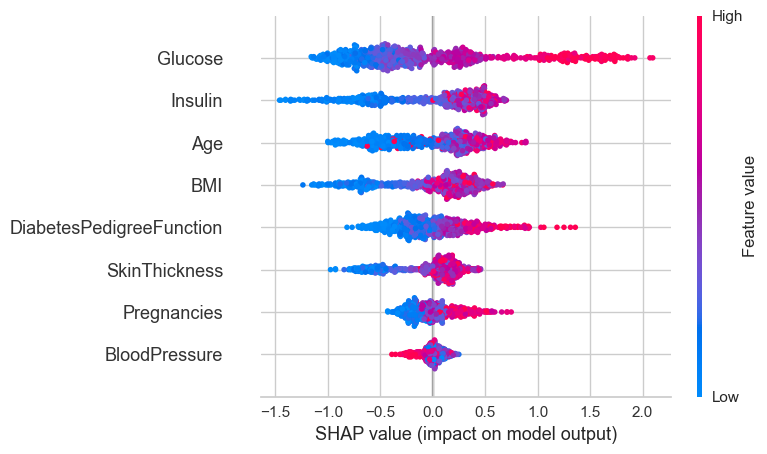

In [67]:
shap.summary_plot(shap_values, X_SMOTE)
#plt.savefig('./figuras/shap_value_impact.png')

## ROC curves comparison

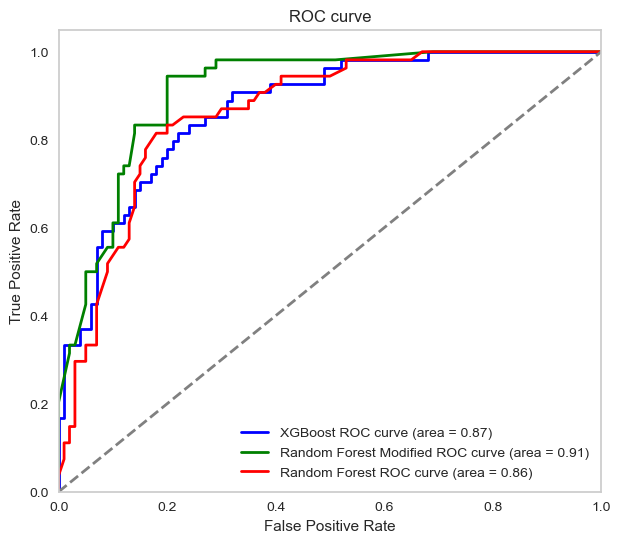

In [63]:
plt.figure(figsize=(7, 6))
plt.plot(fpr_XGBoost, tpr_XGBoost, color='blue', lw=2, label=f'XGBoost ROC curve (area = {roc_auc_XGBoost:.2f})')
plt.plot(fpr_RF_mod, tpr_RF_mod, color='green', lw=2, label=f'Random Forest Modified ROC curve (area = {roc_auc_RF_mod:.2f})')
plt.plot(fpr_RF, tpr_RF, color='red', lw=2, label=f'Random Forest ROC curve (area = {roc_auc_RF:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.grid()

plt.show()